In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [292]:
pd.DataFrame({'sim':[1,2,3],'j':range(3)}).set_index('j')

,sim
j,
0,1
1,2
2,3


# Definindo as funções

In [293]:
# splines naturais

class NaturalCubicSpline:
    def __init__(self, lx, ly):
        self.lx = lx
        self.ly = ly
        self.n = len(lx)
        self.a = self.ly[:-1]
        self.b, self.c, self.d = self.gera_spline()
        self.coefs = [np.array(self.a), self.b, self.c, self.d]
    def gera_spline(self):
        # implementação do algorítmo 3.4
        h = list()
        for i in range(self.n - 1):
            h.append(self.lx[i + 1] - self.lx[i])
        alpha = [0.0]
        for i in range(1, self.n - 1):
            res = (3 * (self.ly[i + 1] - self.ly[i]) / h[i]) - ( 3 * (self.ly[i] - self.ly[i - 1]) / h[i - 1] )
            alpha.append(res)
        l = [1.0]
        u = [0.0]
        z = [0.0]
        for i in range(1, self.n - 1):
            l.append(2 * (self.lx[i + 1] - self.lx[i - 1]) - (h[i - 1] * u[i - 1]))
            u.append(h[i] / l[i])
            z.append((alpha[i] - h[i - 1] * z[i - 1]) / l[i])
        l.append(1.0)
        z.append(0.0)
        b = np.array([0.0 for i in range(self.n)])
        c = np.array([0.0 for i in range(self.n)])
        d = np.array([0.0 for i in range(self.n)])
        for j in range(self.n - 2, -1, -1):
            c[j] = z[j] - u[j] * c[j + 1]
            b[j] = (self.ly[j + 1] - self.ly[j]) / h[j] - h[j] * ( c[j + 1] + 2 * c[j] ) / 3
            d[j] = (c[j + 1] - c[j]) / (3 * h[j])
        return b[:-1], c[:-1], d[:-1]

    def polinom(self, p):
        if p < self.lx[0] or p > self.lx[self.n - 1]:
            return 0
        for i in range(self.n - 1):
            if p >= self.lx[i] and p <= self.lx[i+1]:
                X = p - self.lx[i]
                return (  self.a[i] + self.b[i] * X + self.c[i] * X ** 2 + self.d[i] * X ** 3 )




In [294]:
# splines fixos

class FixedCubicSpline: 
    def __init__(self, lx, ly, FPO, FPN):
        self.lx = lx
        self.ly = ly
        self.n = len(lx)
        self.a = self.ly[:-1]
        self.FPO = FPO
        self.FPN = FPN
        self.b, self.c, self.d = self.gera_spline()
        self.coefs = [np.array(self.a), self.b, self.c, self.d]
    def gera_spline(self):
        # implementação do algorítmo 3.5
        h = list()
        for i in range(self.n - 1):
            h.append(self.lx[i + 1] - self.lx[i])
        alpha = [3*(self.ly[1]-self.ly[0])/h[0] - 3*self.FPO]
        for i in range(1,self.n-1):
            res = (3 * (self.ly[i + 1] - self.ly[i]) / h[i]) - (3 * (self.ly[i] - self.ly[i - 1]) / h[i - 1])
            alpha.append(res)
        alpha.append(3*self.FPN - 3*(self.ly[self.n-1]-self.ly[self.n-2])/h[self.n-2])
        l = [2*h[0]]
        u = [0.5]
        z = [alpha[0]/l[0]]
        for i in range(1, self.n - 1):
            l.append(2 * (self.lx[i + 1] - self.lx[i - 1]) - (h[i - 1] * u[i - 1]))
            u.append(h[i] / l[i])
            z.append((alpha[i] - h[i - 1] * z[i - 1]) / l[i])
        l.append(h[self.n-2]*(2-u[self.n-2]))  ###
        z.append((alpha[self.n-1]-h[self.n-2]*z[self.n-2])/l[self.n-1])

        b = np.array([0.0 for i in range(self.n)])
        c = np.array([0.0 for i in range(self.n)])
        d = np.array([0.0 for i in range(self.n)])
        c[self.n-1] = z[self.n-1]

        for j in range(self.n - 2, -1, -1):
            c[j] = z[j] - u[j] * c[j + 1]
            b[j] = (self.ly[j + 1] - self.ly[j]) / h[j] - h[j] * (c[j + 1] + 2 * c[j]) / 3
            d[j] = (c[j + 1] - c[j]) / (3 * h[j])
        return b[:-1], c[:-1], d[:-1]


    def polinom(self, p):
        if p < self.lx[0] or p > self.lx[self.n - 1]:
            return 0
        for i in range(self.n-1):
            if p >= self.lx[i] and p <= self.lx[i+1]:
                X = p - self.lx[i]
                return self.a[i] + self.b[i] * X + self.c[i] * X ** 2 + self.d[i] * X ** 3


In [295]:
# polinômio interpolador por diferenças divididas

class DividedDiferences:
    def __init__(self, x, y):
        # x vetor de mesmo tamanho que y
        # algorítmo 3.2 do Burden
        self.x = np.array(x,dtype=np.float64)
        self.y = np.array(y,dtype=np.float64)
        self.n = len(x)
        f = np.zeros((self.n, self.n))
        for k in range(self.n):
            f[k, 0] = self.y[k]
        for i in range(1, self.n):
            for j in range(1, i + 1):
                f[i, j] = (f[i, j - 1] - f[i - 1, j - 1]) / (self.x[i] - self.x[i - j])
        self.coefs = f

    def polinom(self, p):
        # calcular o polinômio interpolador no ponto p
        soma = 0
        for i in range(self.n):
            res = self.coefs[i, i]
            for j in range(i):
                res *= p - self.x[j]
            soma += res
        return soma


# Aplicação 1

### Ruddy duck in flight

In [296]:
# PATO

X = [0.9,1.3,1.9,2.1,2.6,3.0,3.9,4.4,4.7,5.0,6.0,7.0,8.0,9.2,10.5,11.3,11.6,12.0,12.6,13.0,13.3]
Y = [1.3,1.5,1.85,2.1,2.6,2.7,2.4,2.15,2.05,2.1,2.25,2.3,2.25,1.95,1.4,0.9,0.7,0.6,0.5,0.4,0.25]

patoSpline = NaturalCubicSpline(X,Y)
patoPolinomio = DividedDiferences(X,Y)

Xbase = np.linspace(0.9,13.3,100000)
FXSpline = [patoSpline.polinom(x) for x in Xbase]
FXPolinomio = [patoPolinomio.polinom(x) for x in Xbase]

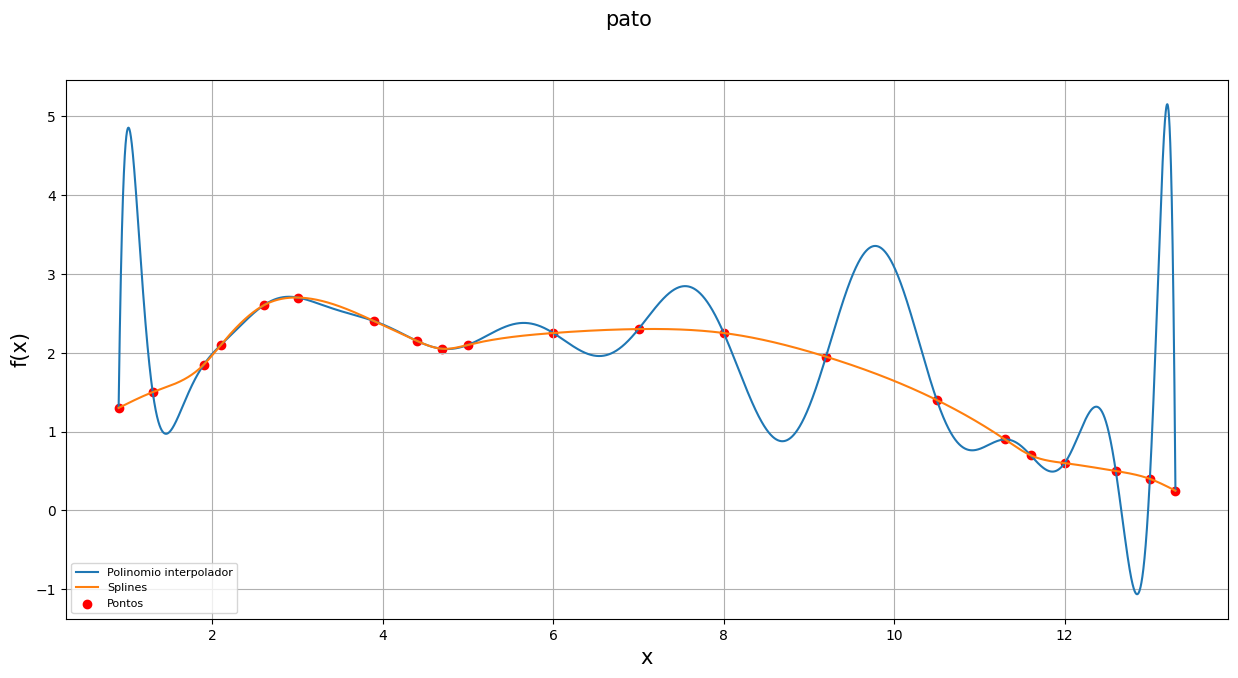

In [297]:

fig = plt.figure(figsize = (15,7))
fig.suptitle('pato', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plt.plot(Xbase, FXPolinomio, label = "Polinomio interpolador")
plt.plot(Xbase, FXSpline, label = "Splines")
plt.scatter(X, Y, label = "Pontos", color = "r")
plt.legend(fontsize=8)

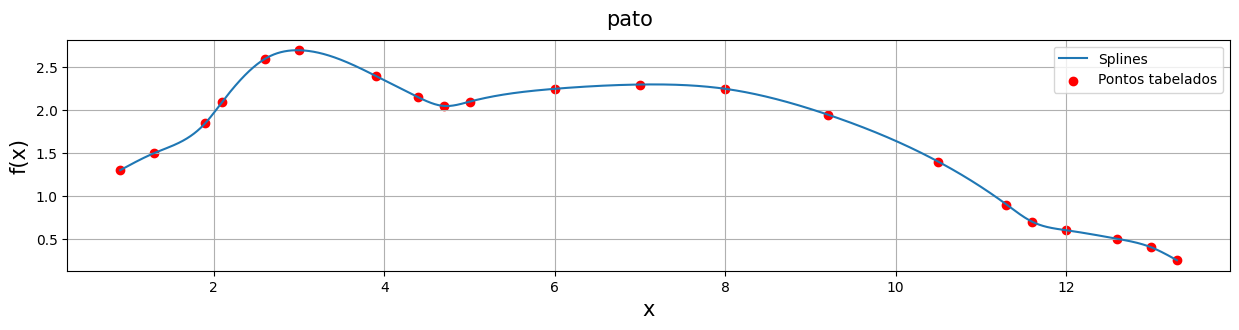

In [298]:
fig = plt.figure(figsize = (15,3))
fig.suptitle('pato', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plot = plt.plot(Xbase, FXSpline, label = "Splines")
plt.scatter(X, Y, label = "Pontos tabelados", color = "r")
plt.legend(fontsize=10)


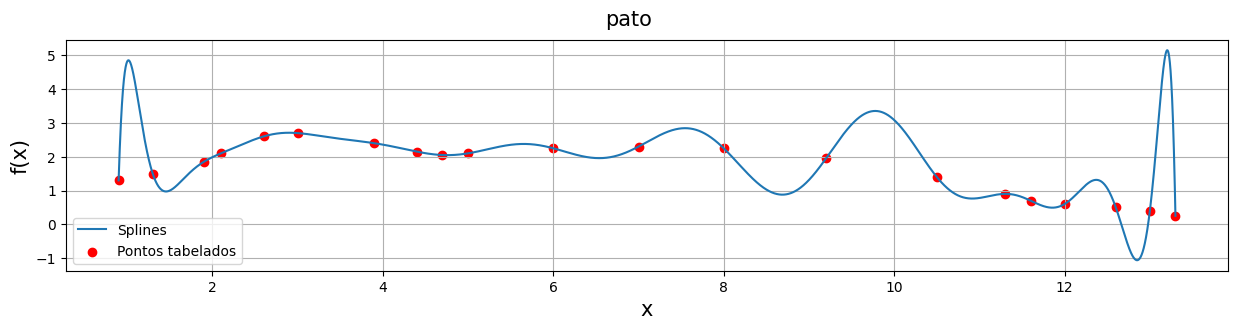

In [299]:
fig = plt.figure(figsize = (15,3))
fig.suptitle('pato', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plot = plt.plot(Xbase, FXPolinomio, label = "Splines")
plt.scatter(X, Y, label = "Pontos tabelados", color = "r")
plt.legend(fontsize=10)

In [300]:
# coeficientes spline

pd.DataFrame({
    'A':patoSpline.a,
    'B':patoSpline.b,
    'C':patoSpline.c,
    'D':patoSpline.d,
})

,A,B,C,D
0,1.30,0.539624,0.000000,-0.247649
1,1.50,0.420752,-0.297179,0.946912
2,1.85,1.086803,1.407263,-2.956382
3,2.10,1.294942,-0.366567,-0.446635
4,2.60,0.593399,-1.036519,0.445051
5,2.70,-0.022191,-0.502457,0.174160
6,2.40,-0.503406,-0.032226,0.078076
7,2.15,-0.477075,0.084888,1.314171
8,2.05,-0.071316,1.267642,-1.581219
9,2.10,0.262340,-0.155455,0.043115


In [301]:
# coeficientes polinomio de newton

pd.DataFrame({'coeficientes':[patoPolinomio.coefs[i,i] for i in range(len(patoPolinomio.coefs))]})

,coeficientes
0,1.300000e+00
1,5.000000e-01
2,8.333333e-02
3,6.250000e-01
4,-9.063241e-01
5,5.668351e-01
6,-1.839119e-01
7,3.874691e-02
8,-2.548150e-03
9,-1.858675e-03


### Noble beast

In [302]:
# CACHORRO

X1 = [1,2,5,6,7,8,10,13,17]
Y1 = [3.0,3.7,3.9,4.2,5.7,6.6,7.1,6.7,4.5]
FPO1 = 1.0
FPN1 = -2/3
#FPN1 = -0.67

X2 = [17,20,23,24,25,27,27.7]
Y2 = [4.5,7.0,6.1,5.6,5.8,5.2,4.1]
FPO2 = 3.0
FPN2 = -4.0

X3 = [27.7,28,29,30]
Y3 = [4.1,4.3,4.1,3.0]
FPO3 = 1/3
#FPO3 = 0.33
FPN3 = -1.5

X = [1,2,5,6,7,8,10,13,17,20,23,24,25,27,27.7,28,29,30]
Y =  [3.0,3.7,3.9,4.2,5.7,6.6,7.1,6.7,4.5,7.0,6.1,5.6,5.8,5.2,4.1,4.3,4.1,3.0]

cachorro1 = FixedCubicSpline(X1,Y1,FPO1,FPN1)
cachorro2 = FixedCubicSpline(X2,Y2,FPO2,FPN2)
cachorro3 = FixedCubicSpline(X3,Y3,FPO3,FPN3)


def splineCachorro(x):
    if x <= 17:
        return cachorro1.polinom(x)
    if x <= 27.7:
        return cachorro2.polinom(x)
    else:
        return cachorro3.polinom(x)

cachorroPolinomio = DividedDiferences(X,Y)

Xbase = np.linspace(1,30,30000)
FXSpline = [splineCachorro(x) for x in Xbase]
FXPolinomio = [cachorroPolinomio.polinom(x) for x in Xbase]

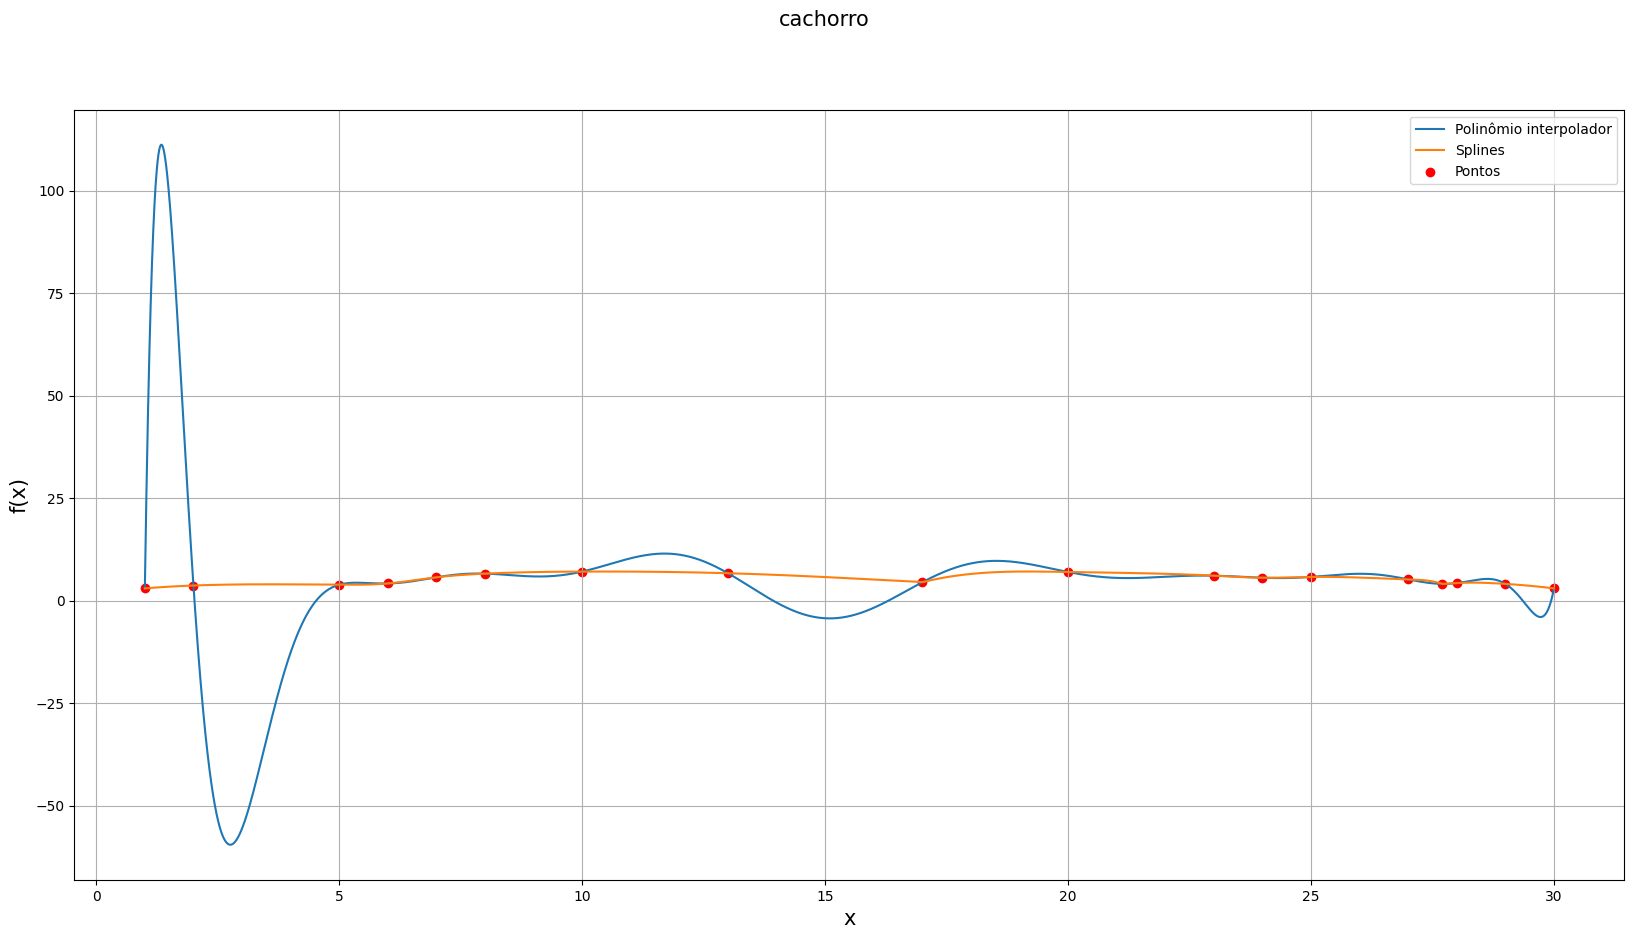

In [303]:
fig = plt.figure(figsize = (20,10))
fig.suptitle('cachorro', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plot = plt.plot(Xbase, FXPolinomio, label = "Polinômio interpolador")
plot = plt.plot(Xbase, FXSpline, label = "Splines")
plt.scatter(X, Y, label = "Pontos", color = "r")
plt.legend(fontsize=10)

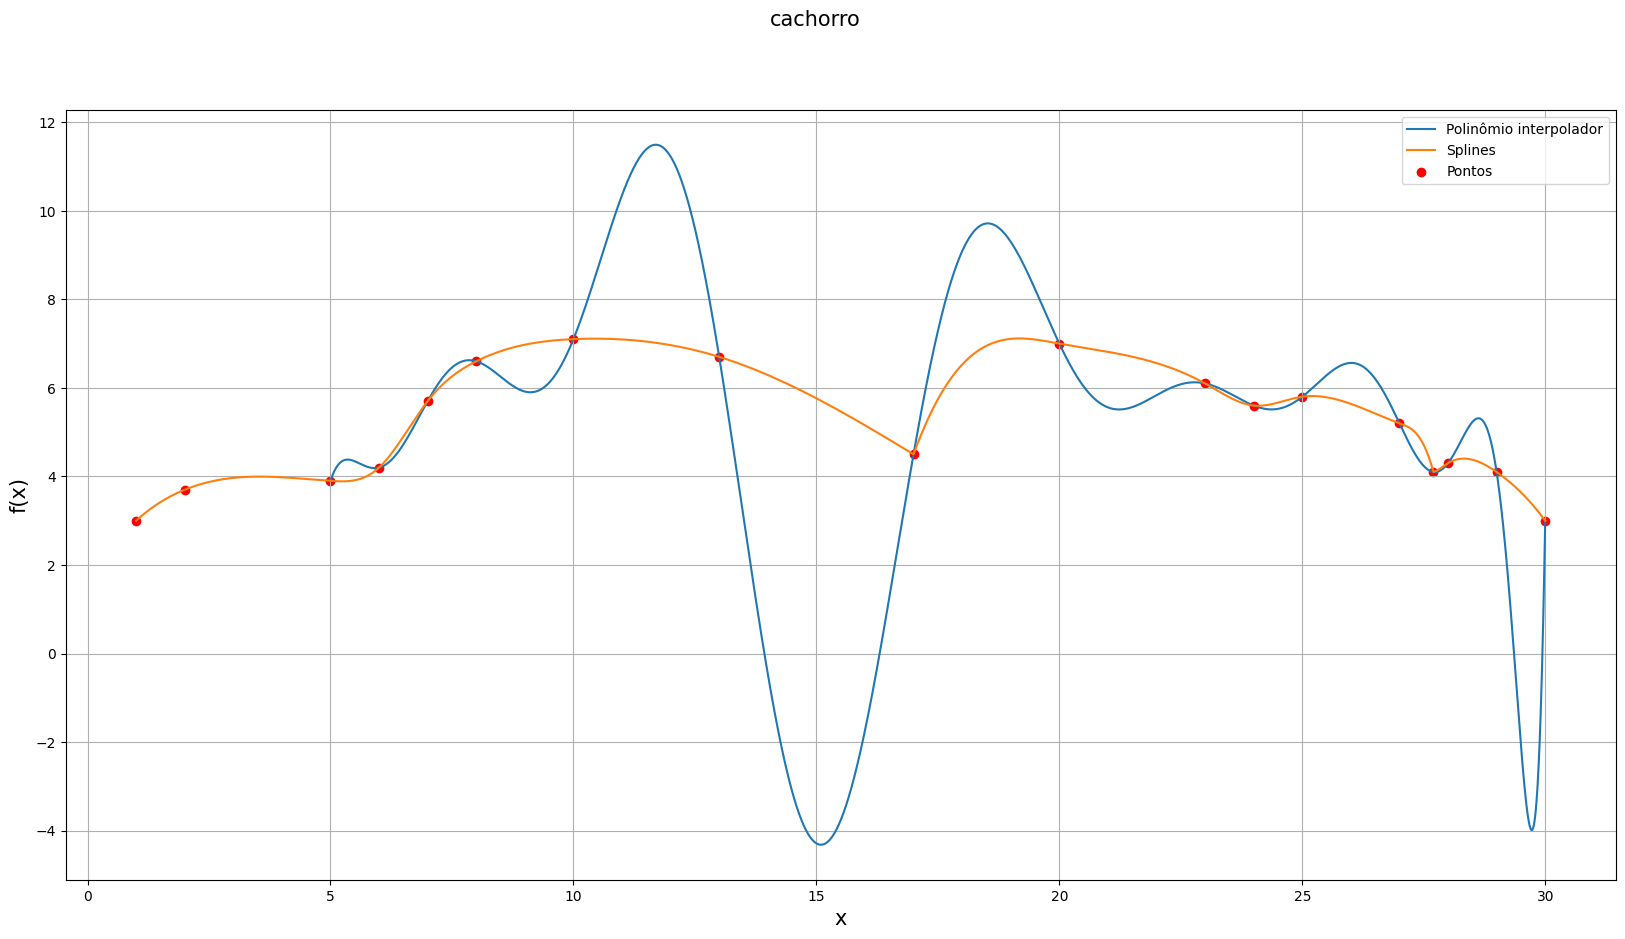

In [304]:
fig = plt.figure(figsize = (20,10))
fig.suptitle('cachorro', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plt.plot(Xbase[4150:], FXPolinomio[4150:], label = "Polinômio interpolador")
plot = plt.plot(Xbase, FXSpline, label = "Splines")
plt.scatter(X, Y, label = "Pontos", color = "r")
plt.legend(fontsize=10)

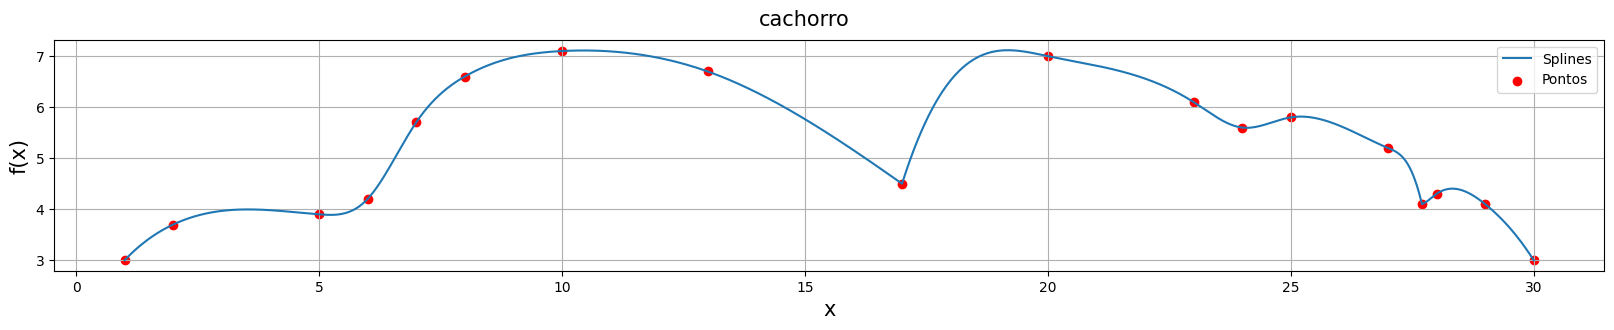

In [ ]:

fig = plt.figure(figsize = (20,3))
fig.suptitle('cachorro', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plot = plt.plot(Xbase, FXSpline, label = "Splines")
plt.scatter(X, Y, label = "Pontos", color = "r")
plt.legend(fontsize=10)

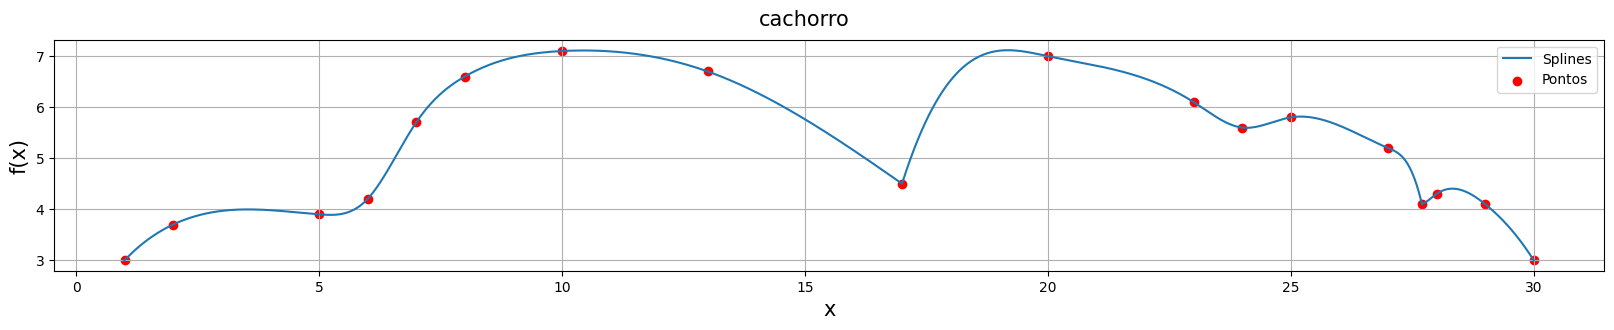

In [ ]:
fig = plt.figure(figsize = (20,3))
fig.suptitle('cachorro', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plot = plt.plot(Xbase, FXSpline, label = "Splines")
plt.scatter(X, Y, label = "Pontos", color = "r")
plt.legend(fontsize=10)

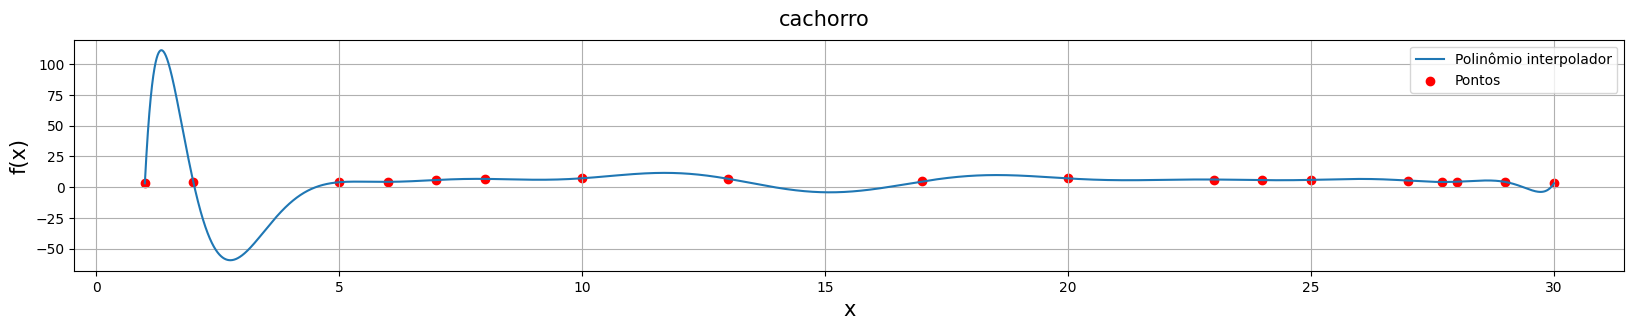

In [ ]:
fig = plt.figure(figsize = (20,3))
fig.suptitle('cachorro', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plot = plt.plot(Xbase, FXPolinomio, label = "Polinômio interpolador")
plt.scatter(X, Y, label = "Pontos", color = "r")
plt.legend(fontsize=10)

In [ ]:

# coeficientes
A_Cachorro = list(cachorro1.a) + list(cachorro2.a) + list(cachorro3.a)
B_Cachorro = list(cachorro1.b) + list(cachorro2.b) + list(cachorro3.b)
C_Cachorro = list(cachorro1.c) + list(cachorro2.c) + list(cachorro3.c)
D_Cachorro = list(cachorro1.d) + list(cachorro2.d) + list(cachorro3.d)

pd.DataFrame({
    'A':A_Cachorro,
    'B':B_Cachorro,
    'C':C_Cachorro,
    'D':D_Cachorro,
})

,A,B,C,D
0,3.0,1.000000,-0.346810,0.046810
1,3.7,0.446810,-0.206380,0.026555
2,3.9,-0.074480,0.032617,0.341863
3,4.2,1.016343,1.058205,-0.574548
4,5.7,1.409109,-0.665439,0.156329
5,6.6,0.547220,-0.196450,0.023920
6,7.1,0.048460,-0.052930,-0.002556
7,6.7,-0.338131,-0.075934,0.005742
8,4.5,3.000000,-1.100708,0.126162
9,7.0,-0.197875,0.034750,-0.022931


In [ ]:
# coeficientes polinomio de newton

pd.DataFrame({'coeficientes':[cachorroPolinomio.coefs[i,i] for i in range(len(cachorroPolinomio.coefs))]})

,coeficientes
0,3.000000e+00
1,7.000000e-01
2,-1.583333e-01
3,4.333333e-02
4,1.083333e-02
5,-1.126984e-02
6,3.088624e-03
7,-4.430215e-04
8,3.966125e-05
9,-2.765838e-06


### Aplicação 2

In [ ]:
t = [1,2,3,4,5,6]
theta = [1.0,1.25,1.75,2.25,3.0,3.15]

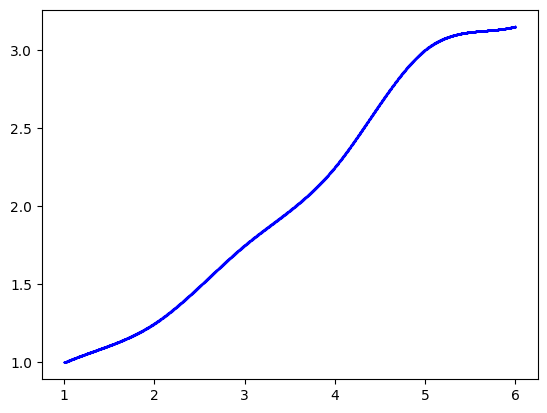

In [ ]:
robo = FixedCubicSpline(t,theta,0.25,0.15)


Xbase = np.linspace(1,6,10000)
FX = [robo.polinom(x) for x in Xbase]
plt.figure()
plt.plot(Xbase, FX, "bh", linewidth=1.1,markersize=0.2)
plt.show()


In [ ]:
robo.polinom(1.5)

1.1087320574162678

In [ ]:
robo.coefs

[array([1.  , 1.25, 1.75, 2.25, 3.  ]),
 array([0.25      , 0.38014354, 0.47942584, 0.70215311, 0.46196172]),
 array([-0.13014354,  0.26028708, -0.16100478,  0.38373206, -0.62392344]),
 array([ 0.13014354, -0.14043062,  0.18157895, -0.33588517,  0.31196172])]

In [ ]:
def deriv(f,x,h=0.01):
    return (f(x+h)-f(x))/h

deriv(robo.polinom,1.5)

0.21812784688994835